In [1]:
import os
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow.keras.backend import clear_session
from tensorflow_probability import distributions as tfd
import functions.functions as funs

# Set the random generators for reproducibility.
os.environ['PYTHONHASHSEED']=str(12345)
random.seed(12345)
rng = np.random.default_rng(12345)
tf.random.set_seed(12345)

# Configure a new global `tensorflow` session:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2023-02-28 23:53:17.784860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


A *Convulutional Neural Netwrok*  (CNN) is an area in deep learning that is used in pattern recognition – or image recognition, specifically tasks involving pixel data. A deep learning CNN consists of three layers: 
1. a convulutional layer
2. a pooling layer
3. a fully connected layer.  

In [2]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [12]:
mnist = pd.read_csv('../Data/mnist.csv', index_col=0)

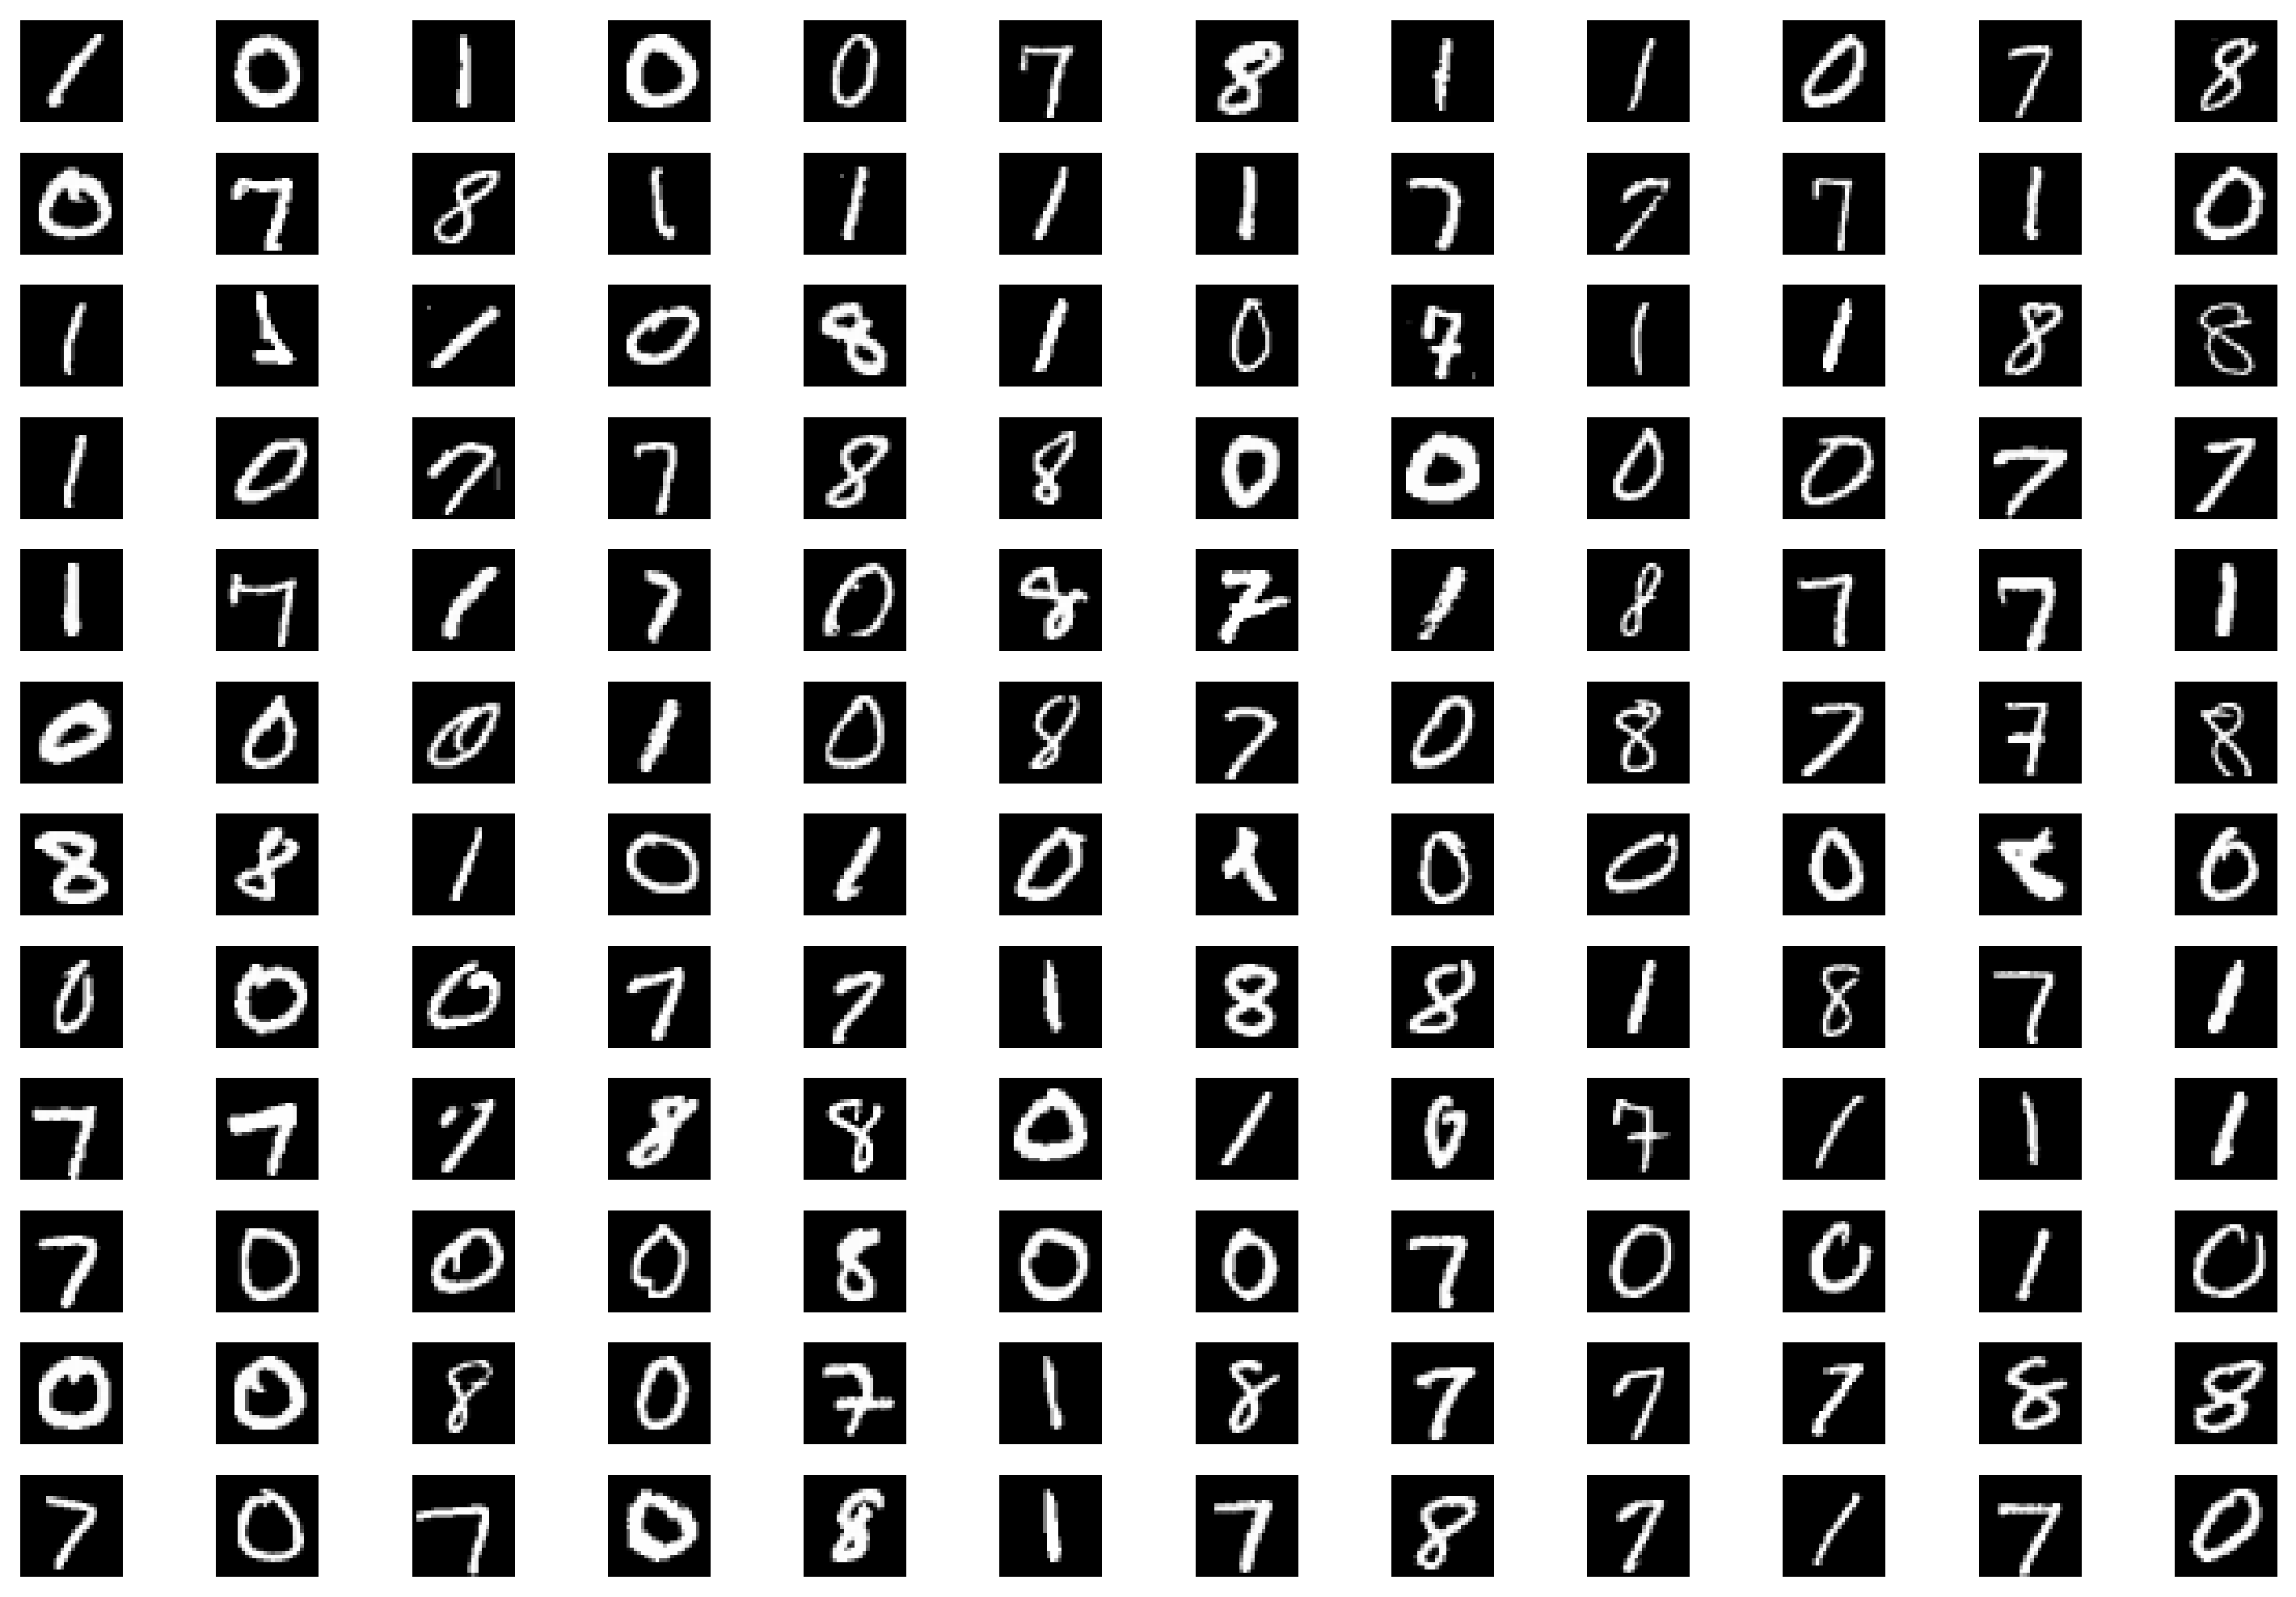

In [13]:
funs.plt_params(250, 12, 8)
funs.inspect_images(mnist, 144)

In [16]:
y = mnist.label.astype('str')
X = mnist.drop('label', axis=1)

In [17]:
X_train, X_test, X_valid, y_train, y_test, y_valid = funs.transform(X, y, 10, 'classifier')

### 1. Standard – *deterministic* – Convulutional Neural Network

In [18]:
def reshaper(data, input_shape):
    return data.reshape(data.shape[0], *input_shape)

In [19]:
X_train = reshaper(X_train, (28, 28, 1))
X_valid = reshaper(X_valid, (28, 28, 1))
X_test = reshaper(X_test, (28, 28, 1))

In [21]:
model = keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (6,6), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(6, 6)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
 ])

In [22]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metrics = model.evaluate(X_test, y_test, verbose=0)

KeyboardInterrupt: 

### 2. Known Unkowns: The *Aleatoric* Uncertainty 

Probabilistic Convulutional Neural Network

In [ ]:
model = keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (6,6), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(6, 6)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
    tfp.OneHotCategorical(10)
])
    
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss=negloglike, metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metrics = model.evaluate(X_test, y_test, verbose=0)

## Introducing Bayesian Deep Learning

#### Prior Distribution 
$$\pi \left ( \mathbf{W} \right) \sim \mathrm{N} \left( 0, 1 \right)$$

In [ ]:
def prior_fn(kernel_size, bias_size, dtype=None):
    # Define the prior weight distribution as Normal(0, 1).
    # The prior is not trainable as the parameters are fixed.
    n = kernel_size + bias_size
    prior = keras.Sequential([
                tfp.layers.DistributionLambda(lambda t: 
                    tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))),
        ])

    return prior

$$\pi \left ( \mathbf{W} \right) \sim \mathrm{N} \left( \mu, 1 \right)$$

In [ ]:
def prior_two(kernel_size, bias_size=0, dtype=None):
    # Define the prior weight distribution as Normal(Xn, 1).
    # The prior is has trainable mean based on the data.
    n = kernel_size + bias_size
    prior = tf.keras.Sequential([
                tfp.layers.VariableLayer(n, dtype=dtype),
                tfp.layers.DistributionLambda(lambda t: 
                    tfd.Independent(tfd.Normal(loc=t, scale=1),reinterpreted_batch_ndims=1)),
    ])

    return prior 

#### Posterior Distribution 

$$P \left( \mathbf{w} \mid \mathcal{D} \right) \sim \mathcal{N}_k \left( \bar{\mu}, \: \bar{\Sigma} \right)$$

$$ \bar{\mu} = \mathbb{E} \left[ \mathbf{X} \right] = \left( \mathbb{E}[X_1], \; \mathbb{E}[X_1], \; ..., \; \mathbb{E}[X_k] \right)$$

In [ ]:
def posterior_fn(kernel_size, bias_size, dtype=None):
    # Define variational posterior weight distribution as multivariate Gaussian.
    # Note that the learnable parameters for this distribution are the means, variances, and covariances.
    n = kernel_size + bias_size
    posterior = keras.Sequential([
                    tfp.layers.VariableLayer(
                        tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype), 
                        tfp.layers.MultivariateNormalTriL(n),
    ])
    return posterior

$$P \left( \mathbf{w} \mid \mathcal{D} \right ) \sim \mathrm{N} \left( \mu_{\mathbf{x}},  \sigma^{2}_{\mathbf{x}} \right)$$


$$ \mu_x = \mathbb{E} \left [ \mathbf{\hat{y}} \mid \mathbf{x},\mathbf{w} \right ] = \mathbf{xw}$$

In [ ]:
def posterior_two(kernel_size, bias_size=0, dtype=None):
    # Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    posterior =  tf.keras.Sequential([
                    tfp.layers.VariableLayer(2 * n, dtype=dtype),
                    tfp.layers.DistributionLambda(lambda t: 
                        tfd.Independent(tfd.Normal(loc=t[..., :n], scale=1e-5 + tf.nn.softplus(c + t[..., n:])), 
                        reinterpreted_batch_ndims=1)),

    ])

    return posterior

### 3. Unknown Unkowns: The *Epistemic Uncertainty*

### 4. Known and Unkown Unkowns: The *Aleatoric* & *Epistemic* Uncertainty 


In [ ]:
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / X_train.shape[0]

In [ ]:
bayesian_model = keras.models.Sequential([
    tfp.Convolution2DReparameterization(filters=8, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1), kernel_divergence_fn=divergence_fn, bias_divergence_fn=divergence_fn),
    tf.kera.layers.MaxPooling2D(pool_size=(6, 6)),
    tf.keras.layers.Flatten(),
    tfp.DenseVariational(10, make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=weight, activation='softmax'),
    tfp.OneHotCategorical(10)
])

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss=negloglike, metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metrics = model.evaluate(X_test, y_test, verbose=0)

Alterante Prior: *Spike \& Slab*

In [ ]:
def prior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size

    prior = keras.Sequential([
        tfp.DistributionLambda(lambda t: 
                tfd.Mixture(
                        categorical = tfd.Categorical(probs=[0.5, 0.5]),
                        components = [
                                tfd.Independent(tfd.Normal(loc=tf.zeros(n), scale=1.0 * tf.ones(n)), reinterpreted_batch_ndims=1),
                                tfd.Independent(tfd.Normal(loc=tf.zeros(n), scale=10.0 * tf.ones(n)), reinterpreted_batch_ndims=1)
                        ],
                )
        )
    ])

    return prior 

*Spike & Slab*

In [ ]:
def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution